# 프로젝트 1-1

In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

(1280, 1920, 3)


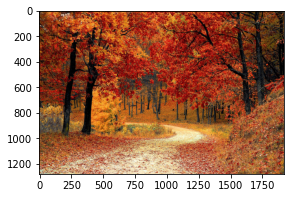

In [10]:
# 고해상도 이미지 불러오기
hr_image = cv2.imread(os.getenv('HOME') + '/aiffel/super_resolution/image/Nature1.jpg')
hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)
hr_shape = hr_image.shape[:2]

print(hr_image.shape)

plt.figure(figsize=(6,3))
plt.imshow(hr_image)

(320, 480, 3)


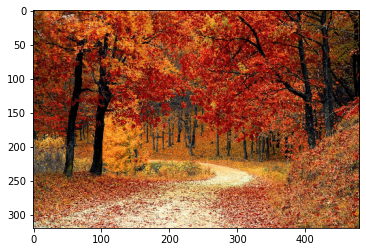

In [11]:
import cv2
lr_image = cv2.resize(hr_image, dsize=(hr_image.shape[1]//4,
                                       hr_image.shape[0]//4)) # (가로 픽셀 수, 세로 픽셀 수)

print(lr_image.shape)

plt.figure(figsize=(8,4))
plt.imshow(lr_image)

In [12]:
# pre-trained 모델 로드
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [13]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

for i, (lr, hr) in enumerate(valid):
    if i == 6: break

srgan_hr = apply_srgan(lr_image)

In [14]:
# bicubic interpolation으로 이미지 사이즈 키우기
bicubic_hr = cv2.resize(
    lr_image, 
    dsize=(hr_image.shape[1], hr_image.shape[0]), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

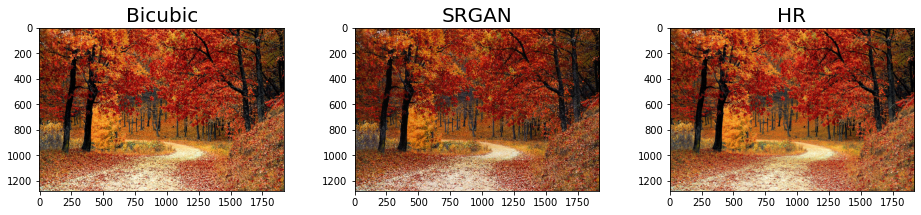

In [15]:
# bicubic interpolation으로 이미지 사이즈 키우기
bicubic_hr = cv2.resize(
    lr_image, 
    dsize=(hr_image.shape[1], hr_image.shape[0]), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

images = [bicubic_hr, srgan_hr, hr_image]
titles = ["Bicubic", "SRGAN", "HR"]

plt.figure(figsize=(16,3))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

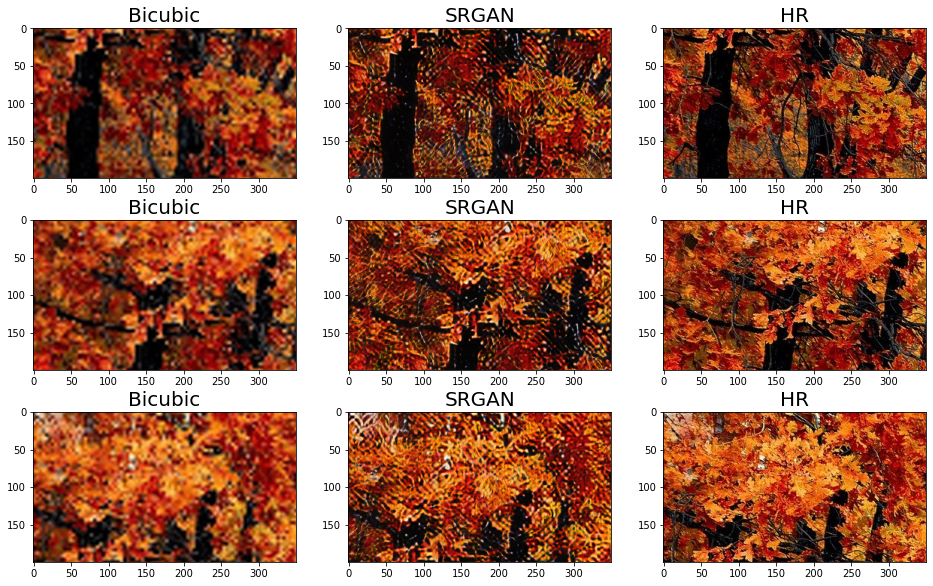

In [16]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=200, y=350):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

# 잘라낼 영역의 좌표를 정의합니다.
left_tops = [(220,200)] *3 + [(90,120)] *3 + [(30,200)] *3

plt.figure(figsize=(16,10))
for i, (image, left_top, title) in enumerate(zip(images*3, left_tops, titles*3)):
    plt.subplot(3,3,i+1)
    plt.imshow(crop(image, left_top))
    plt.title(title, fontsize=20)

고해상도 이미지를 저해상도로 변환한 뒤 다시 고해상도로 복원한 결과 SRGAN이 Bicubic보다 훨씬 선명한것을 볼 수가 있었다.   
하지만 선명하게 보려다보니 원본의 자연스러움이 없어져서 이질감이 든다.

# 프로젝트 1-2

(426, 640, 3)


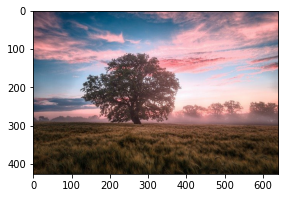

In [17]:
# 저해상도 이미지 불러오기
image = cv2.imread(os.getenv('HOME') + '/aiffel/super_resolution/image/Nature2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_shape = image.shape[:2]

print(image.shape)

plt.figure(figsize=(6,3))
plt.imshow(image)

In [18]:
srgan_hr = apply_srgan(image)

In [19]:
# bicubic interpolation으로 이미지 사이즈 키우기
bicubic_hr = cv2.resize(
    image, 
    dsize=(image.shape[1]*4, image.shape[0]*4), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

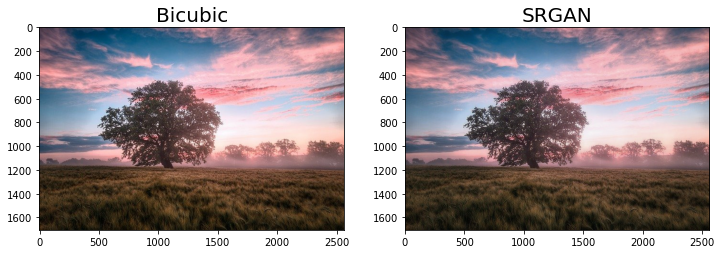

In [20]:
images = [bicubic_hr, srgan_hr]
titles = ["Bicubic", "SRGAN"]

plt.figure(figsize=(12,5))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

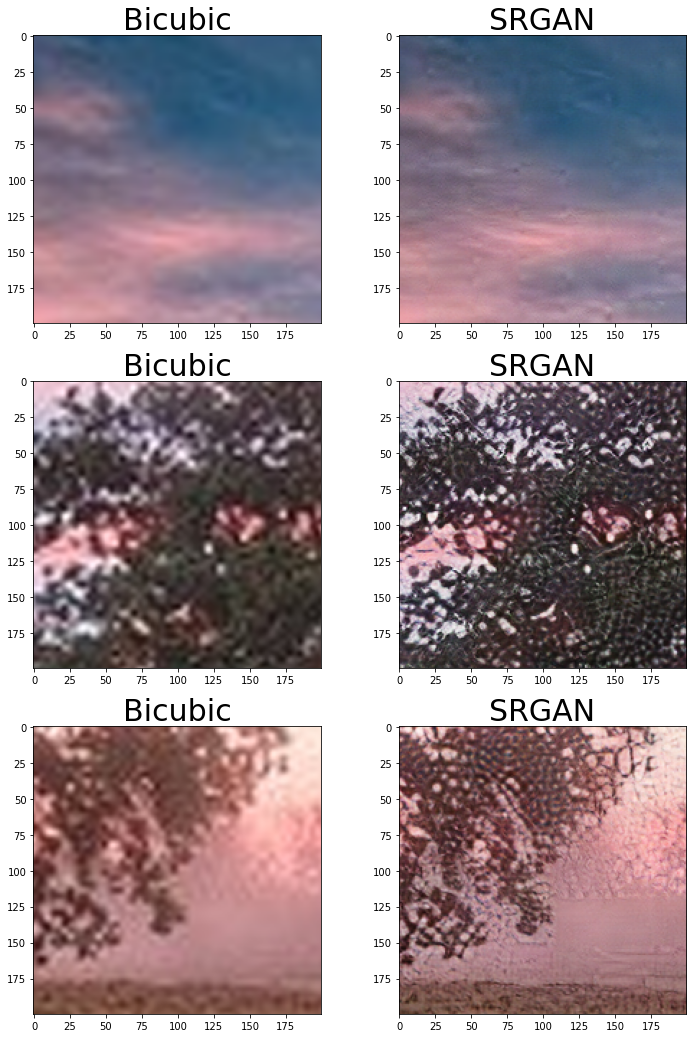

In [21]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(200,300), (500,800), (1000,1300)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    images.extend([img1, img2])

labels = ["Bicubic", "SRGAN"] * 3

plt.figure(figsize=(12,18))
for i in range(6):
    plt.subplot(3,2,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

저해상도 이미지를 고해상도로 만든 경우 Bicubic은 흐리기지만 부드러운 느낌, SRGAN 흐린게 좀 덜한 대신 나뭇잎,나뭇가지처럼 뾰족한 부분은 이구아나피부(?)처럼 보이게 노이즈같은 것이 보이기도 한다. 노이즈를 생각하면 Bicubic이 나아 보이는데 SRGAN도 노이즈를 감안하더라도 뚜렷하게 보인다고 생각해서 나쁘지 않아보인다.

# 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성

1. gif 파일 불러오기

In [22]:
import os
import cv2

# 다운받은 파일의 경로를 설정해 주세요.
gif = cv2.VideoCapture(os.getenv('HOME') +'/aiffel/super_resolution/gif/book_lr.gif')

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 22
frame 크기 : (215, 380, 3)


2. 프레임별 Super Resolution 진행하기

In [23]:
frames_sr_bicubic = []
for frame in frames:
    frames_sr_bicubic.append(cv2.resize(
        frame, 
        dsize=(frame.shape[1]*4, frame.shape[0]*4), 
        interpolation=cv2.INTER_CUBIC
    ))

In [24]:
frames_sr_srgan = []
for frame in frames:
    frames_sr_srgan.append(apply_srgan(frame))

3. 프레임을 합쳐 gif 만들기

In [25]:
import imageio

imageio.mimsave((os.getenv('HOME') +'/aiffel/super_resolution/gif/book_hr_bicubic.gif'), frames_sr_bicubic)
imageio.mimsave((os.getenv('HOME') +'/aiffel/super_resolution/gif/book_hr_srgan.gif'), frames_sr_srgan)

4. Jupyter notebook에 gif 표시하기

In [26]:
from IPython.display import Image as show_gif

# width 는 적당히 큰 값으로 설정해주세요
#show_gif(os.path.join(gif_path, 'book_lr.gif'), width=800)

In [27]:
# 위에서 설정한 width와 같은 값으로 설정
#show_gif(os.path.join(gif_path, 'book_hr_bicubic.gif'), width=800) 

In [28]:
# 위에서 설정한 width와 같은 값으로 설정
#show_gif(os.path.join(gif_path, 'book_hr_srgan.gif'), width=800) 

저해상도 gif를 고해상도로 바꾼경우 bicubic는 막 차이가 나 보이진 않았는데 SRGAN은 확실히 뚜렷해진게 보였다. 책의페이지나 의자같은 경우가 매우 잘 표현된 경우이다.

gif 링크 : https://drive.google.com/drive/folders/1_V6izMA6P8Nc6O44n6d2AVACGiXyAsj2?usp=sharing

---
# 회고
+ 모두 srgan을 통해 생성된 이미지를 생성하였다. 
+ 다양한 해상도의 이미지에 대한 결과를 보았을 때는 시각적으로 확인이 거의 안되었지만 확대를 하였을때 그 결과는 명확히 차이가 있었다.
+ 저해상도 원본gif와 고해상도gif의 해상도 차이가 시각적으로 확인이 가능하였다.